In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths
BASE_PATH = Path.cwd().parent
OUTPUT_PATH = BASE_PATH / 'output'
DOCS_PATH = BASE_PATH / 'docs'
DOCS_PATH.mkdir(exist_ok=True)

print(f"Output path: {OUTPUT_PATH}")
print(f"Docs path: {DOCS_PATH}")

Output path: /home/pdipasquale/MIIA/stuff/output
Docs path: /home/pdipasquale/MIIA/stuff/docs


## 1. Load Dataset from HuggingFace

In [3]:
from datasets import load_dataset

# Load from HuggingFace
HF_REPO = "pierjoe/execcomp-ai-sample"
ds = load_dataset(HF_REPO, split="train")
print(f"Loaded {len(ds)} records from {HF_REPO}")
ds

Generating train split: 100%|██████████| 1860/1860 [00:01<00:00, 1550.57 examples/s]

Loaded 1860 records from pierjoe/execcomp-ai-sample


Dataset({
    features: ['cik', 'company', 'year', 'filing_date', 'sic', 'state_of_inc', 'filing_html_index', 'accession_number', 'table_image', 'table_body', 'executives'],
    num_rows: 1860
})

In [4]:
# Convert to DataFrame
df = ds.to_pandas()

# Parse executives JSON
df['executives_parsed'] = df['executives'].apply(lambda x: json.loads(x) if pd.notna(x) else [])
df['n_executives'] = df['executives_parsed'].apply(len)

print(f"Total tables: {len(df)}")
print(f"Unique companies: {df['cik'].nunique()}")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")
df.head()

Total tables: 1860
Unique companies: 1380
Year range: 2005 - 2022


,cik,company,year,filing_date,sic,state_of_inc,filing_html_index,accession_number,table_image,table_body,executives,executives_parsed,n_executives
0,78749,AGILYSYS INC,2007,2007-07-02T00:00:00,5065,OH,https://www.sec.gov/Archives/edgar/data/78749/...,0000950152-07-005584,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,<table><tr><td>Name and Principal Position</td...,"[{""name"": ""Arthur Rhein"", ""title"": ""Chairman, ...","[{'name': 'Arthur Rhein', 'title': 'Chairman, ...",5
1,1755237,"Cyclerion Therapeutics, Inc.",2020,2020-04-23T00:00:00,2834,MA,https://www.sec.gov/Archives/edgar/data/175523...,0001140361-20-009594,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,<table><tr><td>Name and Principal Position</td...,"[{""name"": ""Peter M. Hecht, Ph.D."", ""title"": ""C...","[{'name': 'Peter M. Hecht, Ph.D.', 'title': 'C...",3
2,889423,SATCON TECHNOLOGY CORP,2011,2011-05-20T00:00:00,3674,DE,https://www.sec.gov/Archives/edgar/data/889423...,0001047469-11-005393,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,<table><tr><td>Name and principal position</td...,"[{""name"": ""Charles S. Rhoades"", ""title"": ""Chie...","[{'name': 'Charles S. Rhoades', 'title': 'Chie...",15
3,860730,"HCA Holdings, Inc.",2015,2015-03-19T00:00:00,8062,NULL,https://www.sec.gov/Archives/edgar/data/860730...,0001193125-15-098575,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,<table><tr><td>Name and Principal Positions*</...,"[{""name"": ""R. Milton Johnson"", ""title"": ""Presi...","[{'name': 'R. Milton Johnson', 'title': 'Presi...",12
4,882184,HORTON D R INC /DE/,2022,2022-12-13T00:00:00,1531,DE,https://www.sec.gov/Archives/edgar/data/882184...,0001193125-22-303898,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,<table><tr><td>Name andPrincipal Position</td>...,"[{""name"": ""Donald R. Horton"", ""title"": ""Execut...","[{'name': 'Donald R. Horton', 'title': 'Execut...",15


## 2. Pipeline Statistics

In [5]:
# Count stats from output folder
total_docs = 0
funds = 0
with_sct = 0
no_sct = 0
total_tables = 0

for d in OUTPUT_PATH.iterdir():
    if not d.is_dir():
        continue
    total_docs += 1
    
    meta_path = d / "metadata.json"
    if meta_path.exists():
        with open(meta_path) as f:
            meta = json.load(f)
        if meta.get("sic") in ("NULL", None):
            funds += 1
            continue
    
    if (d / "extraction_results.json").exists():
        with_sct += 1
        class_path = d / "classification_results.json"
        if class_path.exists():
            with open(class_path) as f:
                classification = json.load(f)
            total_tables += len(classification.get("tables", []))
    elif (d / "no_sct_found.json").exists():
        no_sct += 1

non_funds = total_docs - funds
extra_tables = total_tables - with_sct

print("="*50)
print("PIPELINE STATISTICS")
print("="*50)
print(f"Total documents processed:  {total_docs:,}")
print(f"  Funds (skipped):          {funds:,}")
print(f"  Non-funds:                {non_funds:,}")
print(f"    ├─ With SCT:            {with_sct:,} ({total_tables:,} tables, {extra_tables} merged)")
print(f"    └─ No SCT:              {no_sct:,}")
print("="*50)

PIPELINE STATISTICS
Total documents processed:  2,000
  Funds (skipped):          376
  Non-funds:                1,624
    ├─ With SCT:            1,528 (1,860 tables, 332 merged)
    └─ No SCT:              96


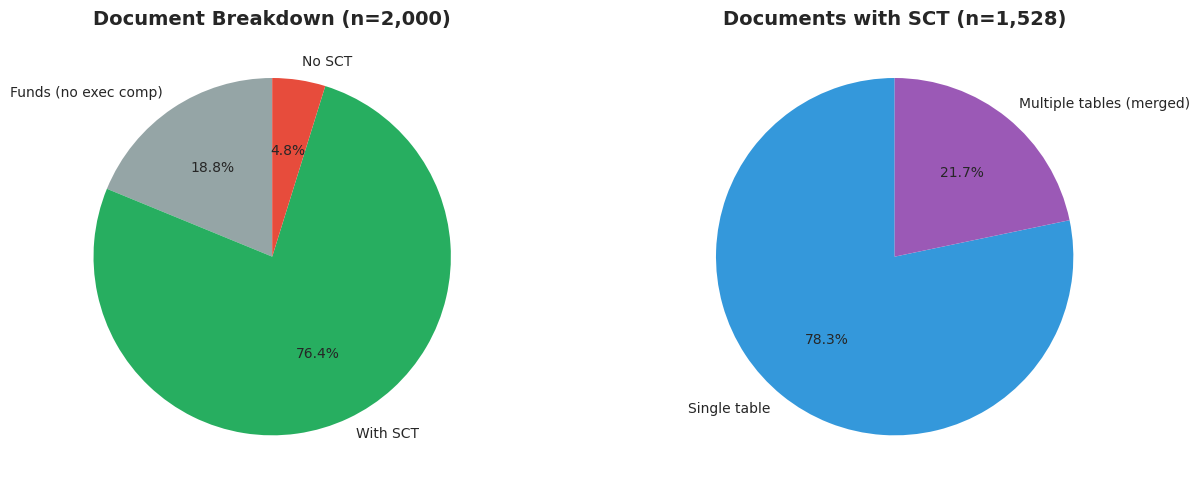

Saved to /home/pdipasquale/MIIA/stuff/docs/pipeline_stats.png


In [6]:
# Pie chart: Document breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: All documents
labels1 = ['Funds (no exec comp)', 'With SCT', 'No SCT']
sizes1 = [funds, with_sct, no_sct]
colors1 = ['#95a5a6', '#27ae60', '#e74c3c']
axes[0].pie(sizes1, labels=labels1, autopct='%1.1f%%', colors=colors1, startangle=90)
axes[0].set_title(f'Document Breakdown (n={total_docs:,})', fontsize=14, fontweight='bold')

# Right: Tables per document
labels2 = ['Single table', 'Multiple tables (merged)']
single = with_sct - (total_tables - with_sct)  # docs with only 1 table
# Actually: with_sct docs, extra_tables extra
# So: (with_sct - extra_tables) have 1 table, extra_tables have 2+
multi_docs = extra_tables  # approx: each extra table = 1 more doc with 2+ tables
single_docs = with_sct - multi_docs
sizes2 = [single_docs, multi_docs]
colors2 = ['#3498db', '#9b59b6']
axes[1].pie(sizes2, labels=labels2, autopct='%1.1f%%', colors=colors2, startangle=90)
axes[1].set_title(f'Documents with SCT (n={with_sct:,})', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(DOCS_PATH / 'pipeline_stats.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to {DOCS_PATH / 'pipeline_stats.png'}")

## 3. Distribution by Year

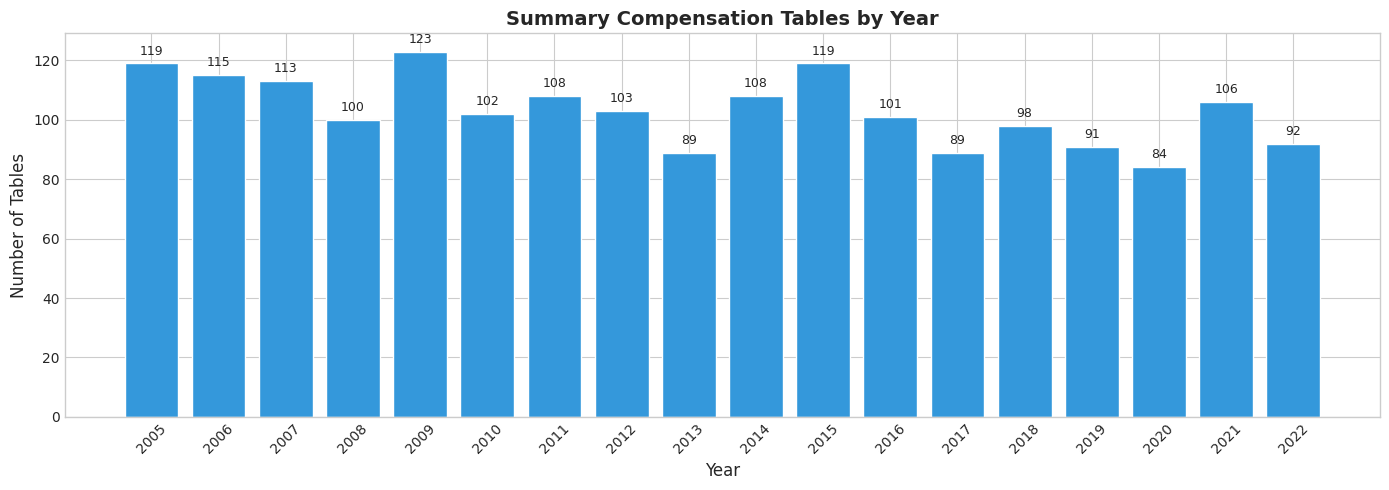

Saved to /home/pdipasquale/MIIA/stuff/docs/tables_by_year.png


In [7]:
# Tables per year
year_counts = df['year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 5))
bars = ax.bar(year_counts.index, year_counts.values, color='#3498db', edgecolor='white')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Tables', fontsize=12)
ax.set_title('Summary Compensation Tables by Year', fontsize=14, fontweight='bold')
ax.set_xticks(year_counts.index)
ax.set_xticklabels(year_counts.index, rotation=45)

# Add value labels
for bar, val in zip(bars, year_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            str(val), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(DOCS_PATH / 'tables_by_year.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to {DOCS_PATH / 'tables_by_year.png'}")

## 4. Executive Compensation Analysis

In [8]:
# Flatten executives into a DataFrame
exec_records = []
for _, row in df.iterrows():
    for exec_data in row['executives_parsed']:
        exec_data['cik'] = row['cik']
        exec_data['company'] = row['company']
        exec_data['filing_year'] = row['year']
        exec_records.append(exec_data)

exec_df = pd.DataFrame(exec_records)
print(f"Total executive records: {len(exec_df):,}")
exec_df.head()

Total executive records: 19,288


,name,title,fiscal_year,salary,bonus,stock_awards,option_awards,non_equity_incentive,change_in_pension,other_compensation,total,cik,company,filing_year
0,Arthur Rhein,"Chairman, President and Chief Executive Officer",2007,725000.0,0.0,0.0,1402080.0,877250.0,1644167.0,182325.0,4830822.0,78749,AGILYSYS INC,2007
1,Martin Ellis,"Executive Vice President, Treasurer and Chief ...",2007,345000.0,0.0,106100.0,372510.0,250470.0,38014.0,200408.0,1312502.0,78749,AGILYSYS INC,2007
2,Robert J. Bailey,Executive Vice President,2007,345000.0,0.0,0.0,284955.0,250470.0,115507.0,161710.0,1157642.0,78749,AGILYSYS INC,2007
3,Peter J. Coleman,Executive Vice President,2007,345000.0,0.0,0.0,277397.0,250470.0,86025.0,220385.0,1179277.0,78749,AGILYSYS INC,2007
4,Richard A. Sayers II,"Executive Vice President, Chief Human Resource...",2007,270000.0,0.0,0.0,333549.0,196020.0,206618.0,238512.0,1244699.0,78749,AGILYSYS INC,2007


In [9]:
# Compensation columns
comp_cols = ['salary', 'bonus', 'stock_awards', 'option_awards', 
             'non_equity_incentive', 'change_in_pension', 'other_compensation', 'total']

# Convert to numeric, coercing errors
for col in comp_cols:
    if col in exec_df.columns:
        exec_df[col] = pd.to_numeric(exec_df[col], errors='coerce')

# Summary statistics
print("Compensation Statistics (USD)")
print("="*60)
stats = exec_df[comp_cols].describe().T[['mean', '50%', 'min', 'max']]
stats.columns = ['Mean', 'Median', 'Min', 'Max']
stats = stats.applymap(lambda x: f"${x:,.0f}" if pd.notna(x) else "N/A")
print(stats)

Compensation Statistics (USD)
                            Mean    Median        Min           Max
salary                  $367,613  $305,992         $0   $20,015,303
bonus                   $125,247        $0   $-93,000   $10,075,000
stock_awards            $674,515   $22,490  $-121,643  $146,123,040
option_awards           $242,384        $0   $-65,340   $44,484,000
non_equity_incentive    $289,961        $0         $0   $44,133,244
change_in_pension        $56,772        $0  $-575,545   $14,197,821
other_compensation       $82,654   $16,164   $-34,154   $15,704,477
total                 $2,116,967  $962,377         $0  $147,695,746


/tmp/ipykernel_1748401/3438355957.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = stats.applymap(lambda x: f"${x:,.0f}" if pd.notna(x) else "N/A")


/tmp/ipykernel_1748401/3559130366.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(labels)


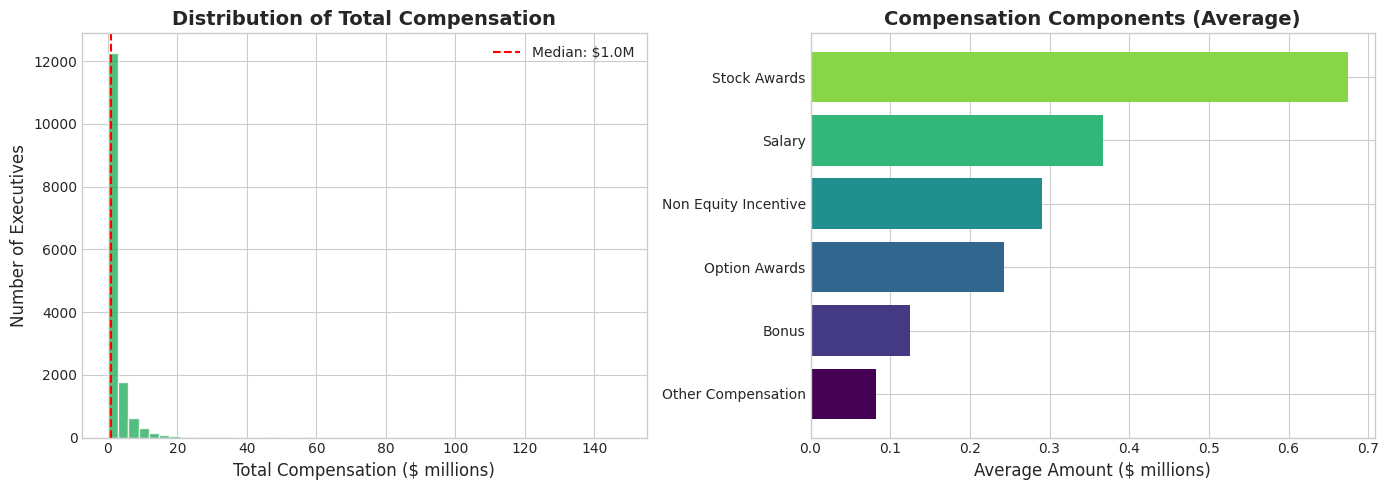

Saved to /home/pdipasquale/MIIA/stuff/docs/compensation_distribution.png


In [10]:
# Distribution of total compensation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram of total comp (log scale for visibility)
total_comp = exec_df['total'].dropna()
total_comp = total_comp[total_comp > 0]  # Remove zeros for log

axes[0].hist(total_comp / 1e6, bins=50, color='#27ae60', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Total Compensation ($ millions)', fontsize=12)
axes[0].set_ylabel('Number of Executives', fontsize=12)
axes[0].set_title('Distribution of Total Compensation', fontsize=14, fontweight='bold')
axes[0].axvline(total_comp.median() / 1e6, color='red', linestyle='--', label=f'Median: ${total_comp.median()/1e6:.1f}M')
axes[0].legend()

# Right: Compensation breakdown (average)
comp_breakdown = exec_df[['salary', 'bonus', 'stock_awards', 'option_awards', 
                          'non_equity_incentive', 'other_compensation']].mean()
comp_breakdown = comp_breakdown.sort_values(ascending=True)

colors = plt.cm.viridis(range(0, 256, 256//len(comp_breakdown)))
axes[1].barh(comp_breakdown.index, comp_breakdown.values / 1e6, color=colors)
axes[1].set_xlabel('Average Amount ($ millions)', fontsize=12)
axes[1].set_title('Compensation Components (Average)', fontsize=14, fontweight='bold')

# Clean labels
labels = [l.replace('_', ' ').title() for l in comp_breakdown.index]
axes[1].set_yticklabels(labels)

plt.tight_layout()
plt.savefig(DOCS_PATH / 'compensation_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to {DOCS_PATH / 'compensation_distribution.png'}")

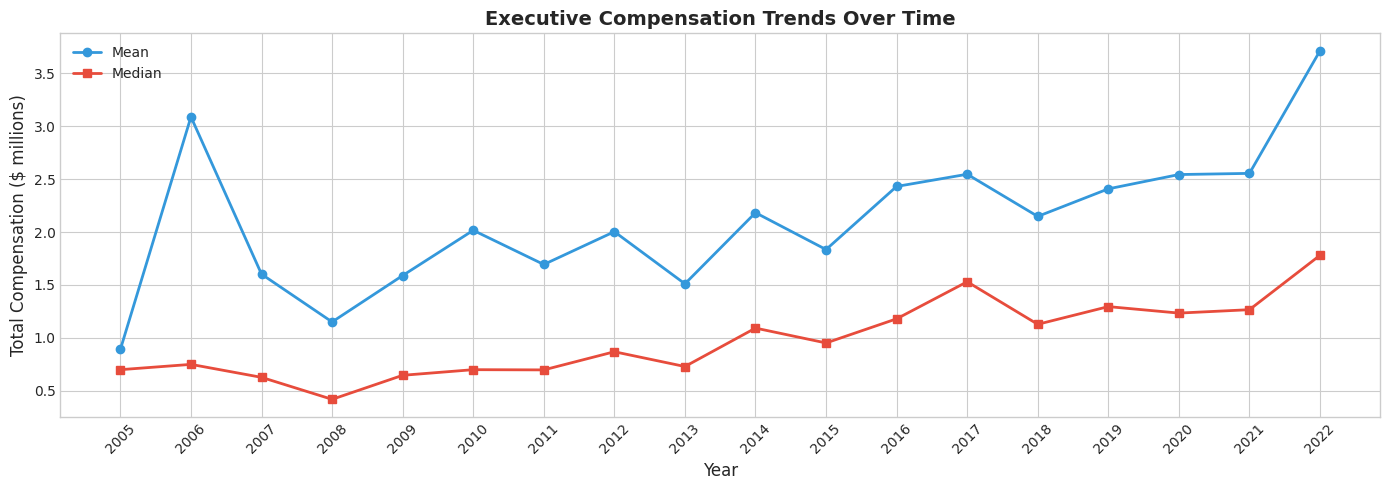

Saved to /home/pdipasquale/MIIA/stuff/docs/compensation_trends.png


In [11]:
# Average total compensation by year
yearly_comp = exec_df.groupby('filing_year')['total'].agg(['mean', 'median']).reset_index()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(yearly_comp['filing_year'], yearly_comp['mean'] / 1e6, 
        marker='o', linewidth=2, label='Mean', color='#3498db')
ax.plot(yearly_comp['filing_year'], yearly_comp['median'] / 1e6, 
        marker='s', linewidth=2, label='Median', color='#e74c3c')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Compensation ($ millions)', fontsize=12)
ax.set_title('Executive Compensation Trends Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xticks(yearly_comp['filing_year'])
ax.set_xticklabels(yearly_comp['filing_year'], rotation=45)

plt.tight_layout()
plt.savefig(DOCS_PATH / 'compensation_trends.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to {DOCS_PATH / 'compensation_trends.png'}")

In [12]:
# Top paid executives
top_execs = exec_df.nlargest(10, 'total')[['name', 'title', 'company', 'filing_year', 'total']].copy()
top_execs['total_fmt'] = top_execs['total'].apply(lambda x: f"${x/1e6:.1f}M")

print("Top 10 Highest Paid Executives")
print("="*80)
for i, row in top_execs.iterrows():
    print(f"{row['name']} ({row['title']})")
    print(f"  {row['company']} ({row['filing_year']}) - {row['total_fmt']}")
    print()

Top 10 Highest Paid Executives
George Kurtz (Chief Executive Officer, President and Director)
  CrowdStrike Holdings, Inc. (2022) - $147.7M

Satya Nadella (Chief Executive Officer and Director)
  MICROSOFT CORP (2014) - $84.3M

Steve Mollenkopf (Chief Executive Officer)
  QUALCOMM INC/DE (2016) - $60.7M

Lisa T. Su (President and Chief Executive Officer)
  ADVANCED MICRO DEVICES INC (2020) - $58.5M

Paul E. Jacobs (Executive Chairman and Chairman of the Board)
  QUALCOMM INC/DE (2016) - $56.9M

Douglas Ingram (President and Chief Executive Officer)
  Sarepta Therapeutics, Inc. (2019) - $56.9M

Donald R. Horton (Executive Chairman)
  HORTON D R INC /DE/ (2022) - $50.6M

James Heppelmann (President and Chief Executive Officer)
  PTC INC. (2019) - $50.0M

David N. Weidman (Chairman and Chief Executive Officer)
  Celanese CORP (2010) - $48.9M

David N. Weidman (Chairman and Chief Executive Officer)
  Celanese CORP (2009) - $48.3M



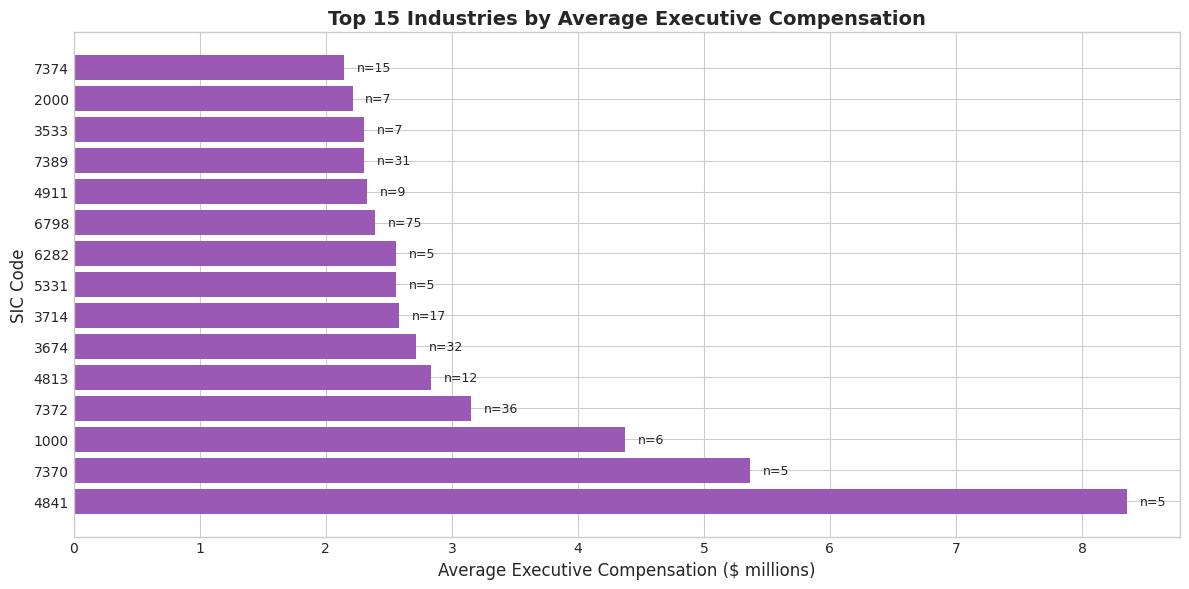

Saved to /home/pdipasquale/MIIA/stuff/docs/compensation_by_industry.png


In [13]:
# Industry analysis by SIC code
sic_comp = df.merge(exec_df.groupby('cik')['total'].mean().reset_index(), on='cik')
sic_summary = sic_comp.groupby('sic').agg({
    'total': 'mean',
    'cik': 'nunique'
}).reset_index()
sic_summary.columns = ['sic', 'avg_comp', 'n_companies']
sic_summary = sic_summary[sic_summary['n_companies'] >= 5]  # At least 5 companies
sic_summary = sic_summary.nlargest(15, 'avg_comp')

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(sic_summary['sic'].astype(str), sic_summary['avg_comp'] / 1e6, color='#9b59b6')
ax.set_xlabel('Average Executive Compensation ($ millions)', fontsize=12)
ax.set_ylabel('SIC Code', fontsize=12)
ax.set_title('Top 15 Industries by Average Executive Compensation', fontsize=14, fontweight='bold')

# Add company count
for bar, n in zip(bars, sic_summary['n_companies']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
            f'n={n}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(DOCS_PATH / 'compensation_by_industry.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to {DOCS_PATH / 'compensation_by_industry.png'}")

## 5. Summary Statistics for README

In [14]:
# Generate summary for README
print("\n" + "="*60)
print("SUMMARY FOR HF README")
print("="*60)
print(f"""
## Dataset Statistics

| Metric | Value |
|--------|-------|
| Total documents processed | {total_docs:,} |
| Funds (no exec comp) | {funds:,} ({funds/total_docs*100:.1f}%) |
| Documents with SCT | {with_sct:,} |
| Documents without SCT | {no_sct:,} |
| Total SCT tables | {total_tables:,} |
| Multi-table documents | {extra_tables:,} |
| Total executive records | {len(exec_df):,} |
| Unique companies | {df['cik'].nunique():,} |
| Year range | {df['year'].min()} - {df['year'].max()} |

## Compensation Statistics

| Metric | Value |
|--------|-------|
| Mean total compensation | ${exec_df['total'].mean()/1e6:.2f}M |
| Median total compensation | ${exec_df['total'].median()/1e6:.2f}M |
| Max total compensation | ${exec_df['total'].max()/1e6:.1f}M |
| Mean salary | ${exec_df['salary'].mean()/1e3:.0f}K |
| Mean stock awards | ${exec_df['stock_awards'].mean()/1e6:.2f}M |
""")


SUMMARY FOR HF README

## Dataset Statistics

| Metric | Value |
|--------|-------|
| Total documents processed | 2,000 |
| Funds (no exec comp) | 376 (18.8%) |
| Documents with SCT | 1,528 |
| Documents without SCT | 96 |
| Total SCT tables | 1,860 |
| Multi-table documents | 332 |
| Total executive records | 19,288 |
| Unique companies | 1,380 |
| Year range | 2005 - 2022 |

## Compensation Statistics

| Metric | Value |
|--------|-------|
| Mean total compensation | $2.12M |
| Median total compensation | $0.96M |
| Max total compensation | $147.7M |
| Mean salary | $368K |
| Mean stock awards | $0.67M |

